In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split


import sqlite3
from datetime import datetime, timedelta
import json


2024-06-16 17:35:59.846955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 17:36:00.854410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Database Connection
con = sqlite3.connect("/home/Arnav/Documents/Projects/occupancy-backend/data.db")
cur = con.cursor()

In [4]:
# Getting and cleaning the data
res = cur.execute("SELECT * FROM gym")
raw_data = res.fetchall()

In [5]:
sch_res = cur.execute("SELECT DISTINCT date, schedule FROM gym_schedule")
sch_data = res.fetchall()

In [6]:
d = datetime.strptime(raw_data[0][1], "%Y-%m-%dT%H:%M:%S")
w = d - timedelta(days=d.weekday(), hours = d.hour, minutes = d.minute, seconds = d.second)
d - w


datetime.timedelta(days=1, seconds=26986)

In [7]:
(datetime.now() - datetime(2024,1,1)).days

167

# Data Prep

In [8]:
class Timing:
  """
  This class represents a timing entry with opening hours, closing hours, and an open boolean.
  """
  def __init__(self, opening, closing, open):
    self.opening = opening
    self.closing = closing
    self.open = open

  def getOpening(self, date):
      hour = self.opening // 100
      minute = self.opening % 100
      return datetime(date.year, date.month, date.day, hour, minute, 0)

  def getClosing(self, date):
      hour = self.closing // 100
      minute = self.closing % 100
      return datetime(date.year, date.month, date.day, hour, minute, 0)

  def __str__(self):
      return f"[Opening: {self.opening}, Closing: {self.closing}]"
      
  def __repr__(self):
      return f"Timing Object: [Opening: {self.opening}, Closing: {self.closing}]"



def parse_timings_json(json_string):
  # Parse the JSON string
  data = json.loads(json_string)

  # Extract timings list and count
  timings = data['timings']
  count = data['count']

  # Convert each timing dictionary to a Timing object
  timing_objects = []
  for timing in timings:
    timing_objects.append(Timing(timing['opening'], timing['closing'], timing['open']))

  return timing_objects

In [9]:
schedule_map = {}
for i in sch_data:
    schedule_map[i[0]] = parse_timings_json(i[1])

In [10]:
# Let the default be the first one - For those that do not have their timings
# Actually, lets make the closing 2230 for weekdays 
default_schedule = schedule_map["2024-05-22"]
for i in range(5):
    default_schedule[i].closing = 2230
default_schedule

[Timing Object: [Opening: 630, Closing: 2230],
 Timing Object: [Opening: 630, Closing: 2230],
 Timing Object: [Opening: 630, Closing: 2230],
 Timing Object: [Opening: 630, Closing: 2230],
 Timing Object: [Opening: 630, Closing: 2230],
 Timing Object: [Opening: 800, Closing: 2100],
 Timing Object: [Opening: 800, Closing: 2100]]

In [11]:
time = []
seasonal = []
occupancy = []
for data in raw_data:
    date = datetime.strptime(data[1], "%Y-%m-%dT%H:%M:%S")
    date_timestamp = date.timestamp()
    date_string = date.strftime("%Y-%m-%d")
    week_day = date.weekday()
    year_start = datetime(date.year, 1,1)
    minimum_day = schedule_map.get(date_string, default_schedule)[week_day].getOpening(date).timestamp()
    maximum_day = schedule_map.get(date_string, default_schedule)[week_day].getClosing(date).timestamp()
    time.append((date_timestamp - minimum_day) / (maximum_day - minimum_day))
    seasonal.append((date - year_start).days / 365)
    occupancy.append(data[2] / 100)

time = np.array(time)
occupancy = np.array(occupancy)
seasonal = np.array(seasonal)

In [12]:
time

array([0.06225694, 0.06746528, 0.07267361, ..., 0.203125  , 0.20833333,
       0.21354167])

In [13]:
occupancy

array([0.11, 0.1 , 0.1 , ..., 0.15, 0.15, 0.14])

In [14]:
seasonal

array([0.38630137, 0.38630137, 0.38630137, ..., 0.38356164, 0.38356164,
       0.38356164])

In [15]:
features = np.vstack((time, seasonal))
features = np.transpose(features)

In [16]:
features

array([[0.06225694, 0.38630137],
       [0.06746528, 0.38630137],
       [0.07267361, 0.38630137],
       ...,
       [0.203125  , 0.38356164],
       [0.20833333, 0.38356164],
       [0.21354167, 0.38356164]])

In [17]:
def create_sequences(features, targets, sequence_length=10):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

In [18]:
sequence_length = 12 * 4
X, y = create_sequences(features, occupancy, sequence_length)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
model = keras.Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 2)))
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2024-06-16 17:36:58.221765: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/Arnav/Documents/Projects/occupancy-prediction/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))


Epoch 1/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 0.0516 - val_loss: 0.0281
Epoch 2/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0257 - val_loss: 0.0235
Epoch 3/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0237 - val_loss: 0.0229
Epoch 4/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0820 - val_loss: 0.0229
Epoch 5/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 320605.0000 - val_loss: 0.0261
Epoch 6/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0247 - val_loss: 0.0227
Epoch 7/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0231 - val_loss: 0.0217
Epoch 8/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0221 - val_loss: 0.0220
Epoch 9/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 0.0216 - val_loss: 0.0214
Epoch 10/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0213 - val_loss: 0.0219
Epoch 11/40
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0212 - val_loss: 0.0207
Epo

In [22]:
loss = model.evaluate(X_test, y_test)

328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0228


1637/1637 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step


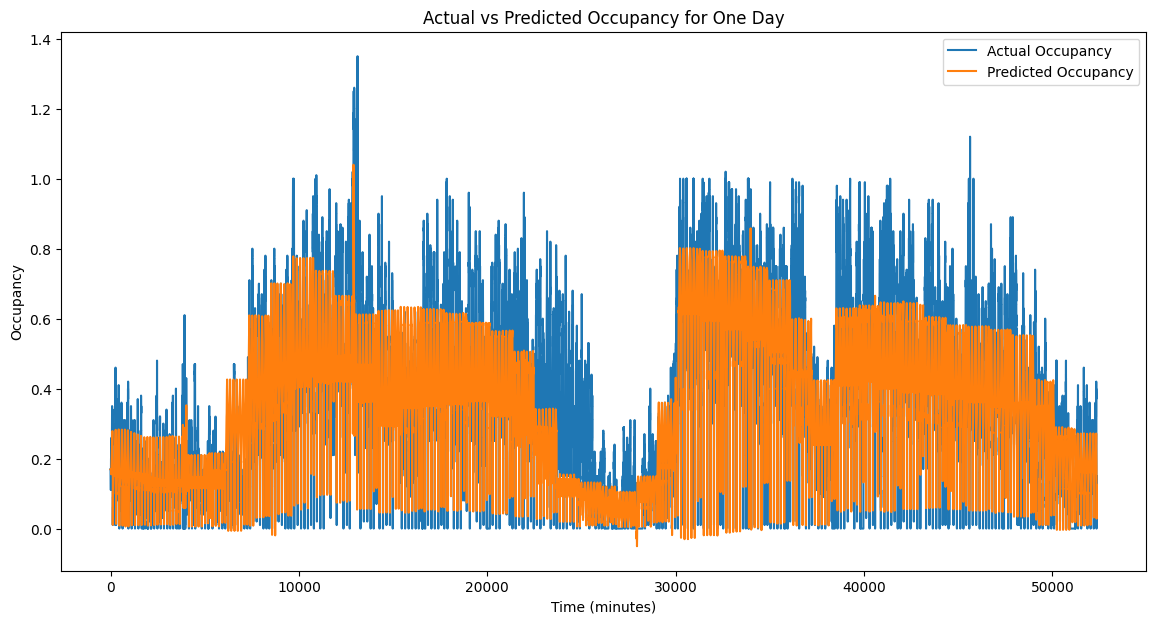

In [23]:
import matplotlib.pyplot as plt

# Assuming the data is in minute intervals and there are 1440 minutes in a day
minutes_in_a_day = 1440
days = 100  # Number of days to predict

# Extract one day's worth of data
X_day = X[:minutes_in_a_day*days]
y_day = y[:minutes_in_a_day*days]

# Reshape X_day for prediction

# Make predictions
predictions = model.predict(X_day)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_day)), y_day, label='Actual Occupancy')
plt.plot(range(len(predictions)), predictions, label='Predicted Occupancy')
plt.xlabel('Time (minutes)')
plt.ylabel('Occupancy')
plt.title('Actual vs Predicted Occupancy for One Day')
plt.legend()
plt.show()


In [29]:
start_time = datetime(2024, 12, 9, 6, 30)
end_time = datetime(2024, 12, 9, 20, 0)
year_start = datetime(2024, 1, 1)
time_interval = timedelta(minutes=5)

In [30]:
times = []
other = []
current_time = start_time
while current_time <= end_time:
    season_number = (current_time - year_start).days / 356
    other.append(current_time)
    times.append([current_time, season_number])
    current_time += time_interval


In [31]:
normalized_times = [[(i.timestamp() - start_time.timestamp()) / (end_time.timestamp() - start_time.timestamp()),s] for (i,s) in times]

In [32]:
np.array(normalized_times)

array([[0.        , 0.96348315],
       [0.00617284, 0.96348315],
       [0.01234568, 0.96348315],
       [0.01851852, 0.96348315],
       [0.02469136, 0.96348315],
       [0.0308642 , 0.96348315],
       [0.03703704, 0.96348315],
       [0.04320988, 0.96348315],
       [0.04938272, 0.96348315],
       [0.05555556, 0.96348315],
       [0.0617284 , 0.96348315],
       [0.06790123, 0.96348315],
       [0.07407407, 0.96348315],
       [0.08024691, 0.96348315],
       [0.08641975, 0.96348315],
       [0.09259259, 0.96348315],
       [0.09876543, 0.96348315],
       [0.10493827, 0.96348315],
       [0.11111111, 0.96348315],
       [0.11728395, 0.96348315],
       [0.12345679, 0.96348315],
       [0.12962963, 0.96348315],
       [0.13580247, 0.96348315],
       [0.14197531, 0.96348315],
       [0.14814815, 0.96348315],
       [0.15432099, 0.96348315],
       [0.16049383, 0.96348315],
       [0.16666667, 0.96348315],
       [0.17283951, 0.96348315],
       [0.17901235, 0.96348315],
       [0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


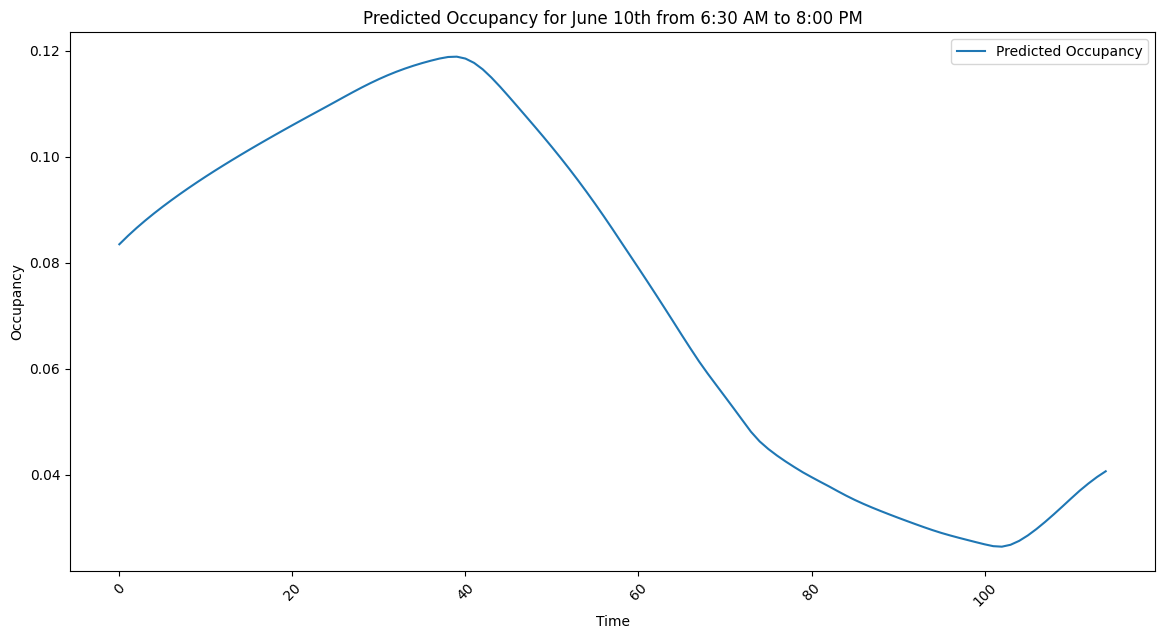

In [33]:
X_pred, _ = create_sequences(normalized_times, [0] * len(normalized_times), sequence_length)

# Reshape the sequences for the LSTM model
# X_pred_reshaped = np.array(X_pred).reshape((len(X_pred), sequence_length, 1))

# Make predictions
predictions = model.predict(X_pred)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(predictions, label='Predicted Occupancy')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Predicted Occupancy for June 10th from 6:30 AM to 8:00 PM')
plt.xticks(rotation=45)
plt.legend()
plt.show()

##### len(other)

In [129]:
len(X_pred)

115

In [131]:
sequence_length

48

In [35]:
model.save("model_3lstm.kera")